In [1]:
from scipy import fft, arange, signal
from scipy.special import logit, expit
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import os
import csv
import pandas as pd
from ttictoc import TicToc
#----------------------
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm, tree
import xgboost
from sklearn.model_selection import train_test_split
#---------------------RF HP-f(x) & CV---------------
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_val_score

In [2]:
folder_root_Hypothesis_1 = "../../Music/hypothesis_1/"
folder_root_Hypothesis_2 = "../../Music/hypothesis_2/"

In [3]:
def read_file(path):
    """
    Reads the audio .wav file and returns the sample rate and data contents of the file.
    """
    sr, signal = wavfile.read(path)
    return sr, signal[:,0]

In [4]:
def read_all(files):
    """Branch audio file extrapolation. Uses read_file() method."""
    ret = []
    t = TicToc()
    t.tic();
    for fl in files:
        ret.append(read_file(fl))
    t.toc();
    print("Time it took to read data from files of length ", len(files), " = ", round(t.elapsed, 3), " seconds.")
    return np.array(ret)

In [5]:
def find_files(PATH, ext):
    """
    Finds all the files in a particular directory. Return only .csv files.
    """
    files = []
    for r, d, f in os.walk(PATH):
        for file in f:
            if ext in file:
                files.append(os.path.join(r, file).replace("\\","/"))
    return files

In [6]:
music_files = find_files(folder_root_Hypothesis_1, ".wav")

In [7]:
data = read_all(music_files)

Time it took to read data from files of length  13  =  3.025  seconds.


In [8]:
def frequency_sepectrum(sf, x):
    """
    Convertion of Audio from time domain to frequency domain using Fast Fourier Algorithm.
    Parameters:
    1. sf : sampling frequency (usually 44.1 KHz)
    2. x : time domain signals.
    Returns:
    1. Sampling rate.
    2. Frequency distribution (Nyquist maintained)
    """
    x = x - np.average(x)  # zero-centered.

    n = len(x)
    k = arange(n)
    tarr = n / float(sf)
    frqarr = k / float(tarr)  # two sides frequency range

    frqarr = frqarr[range(n // 2)]  # one side frequency range

    x = fft(x) / n  # fft computing and normalization
    x = x[range(n // 2)]

    return frqarr, abs(x)

In [9]:
def plot(sample_rate, signal, state=False):
    """
    Method responsible for converting from time domain to frequency
    via the discrete fourier analysis function created in frequency_sepectrum().
    Option to form a plot of the resultant frequency domain graph with its frequency content distribution.
    Returns:
    1. Y: The frequencies.
    2. frq: The content distribution.
    """
    frq, Y = frequency_sepectrum(sample_rate, signal)
    frq = frq
    if(state == True):
        plt.plot(frq, Y)
        plt.title("Frequency (Hz) vs. Magnitude")
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Magnitude")
    return Y, frq

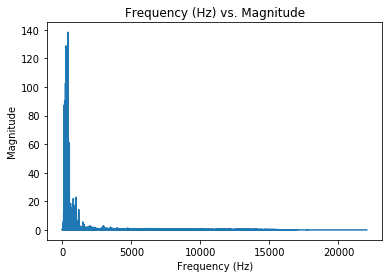

In [10]:
magnitude_0, frequencies_0 = plot(data[-2][0],data[-2][1], True) #Specgram

In [11]:
f, t, Sxx = signal.spectrogram(data[0][1], fs=data[0][0]) #Spectogram

In [12]:
f1, t1, Sxx1 = signal.spectrogram(data[-4][1], fs=data[-4][0]) #Spectogram

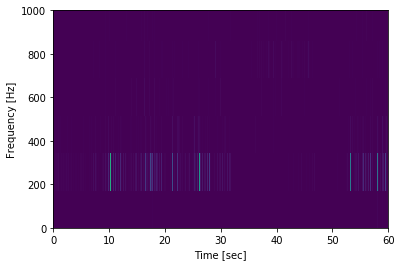

In [13]:
plt.pcolormesh(t, f, Sxx)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim(top=1000)
plt.xlim(right=60)
plt.show()

In [14]:
t.shape, f.shape, Sxx.shape

((37261,), (129,), (129, 37261))

C:\Users\qasim\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:7609: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


Text(0, 0.5, 'Frequency')

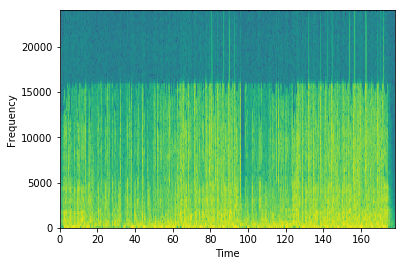

In [15]:
spectrum, freq, time, _ = plt.specgram(data[5][1],Fs=data[5][0])
plt.xlabel('Time')
plt.ylabel('Frequency')

## Part 2. Discrete Foureir Transformation of EEG Data on Same Music files to check for similarities

In [16]:
folder_data = "../../data/Music/"

In [17]:
brain_music_files = find_files(folder_data, ".csv")

In [18]:
def remove_meta_data(PATH):
    """
    Return:
    1. Changes in Electric potential based on Unix timestamp from
        the 5 channels of the Emotiv headset. 2 channels from the Frontal Lobe, 
        1 channel from the parietal lobe, and 2 from temporal lobe.
    2. Pandas Dataframe of the data reflected from (1).
    """
    reader = csv.reader(open(PATH, "rt"), delimiter='\t')
    i = 0
    one_file_data = []
    for line in reader:
        if(i > 0):
            one_file_data.append(line)
        i += 1
    one_file_data = np.array(one_file_data)
    columns = one_file_data[0][0].split(",")[3:8]
    row_data = []
    for rows in one_file_data[1:]:
        dtx = rows[0].split(",")[3:8]
        cont = []
        for x in dtx:
            cont.append(float(x))
        row_data.append(cont)
    dataframe = pd.DataFrame(row_data, columns=columns)
    return np.array(row_data), dataframe

In [19]:
def data_DF_dir(list_PATH):
    """
    Returns all the data from a given set of path files and its associated pandas dataframe object.
    """
    raw_data = []
    dataframes = []
    for file in list_PATH:
        rd, dfob = remove_meta_data(file)
        raw_data.append(rd)
        dataframes.append(dfob)
    return raw_data, dataframes

In [405]:
brain_data, brain_df = data_DF_dir(brain_music_files)

In [406]:
brain_music_files

['../../data/Music/animals1_30.12.19_19.00.21.bp.csv',
 '../../data/Music/animals_2_radio_edit_30.12.19_19.13.11.bp.csv',
 '../../data/Music/an_30.12.19_13.43.35.bp.csv',
 '../../data/Music/clench8_30.12.19_23.16.20.bp.csv',
 '../../data/Music/clenching_1_30.12.19_19.11.24.bp.csv',
 '../../data/Music/clench_1_off_3sec_30.12.19_23.12.47.bp.csv',
 '../../data/Music/guitar_30.12.19_14.11.03.bp.csv',
 '../../data/Music/l1_27.12.19_07.50.35.bp.csv',
 '../../data/Music/party_30.12.19_13.50.37.bp.csv',
 '../../data/Music/piano_30.12.19_14.03.09.bp.csv',
 '../../data/Music/selena0.csv',
 '../../data/Music/selena1.csv']

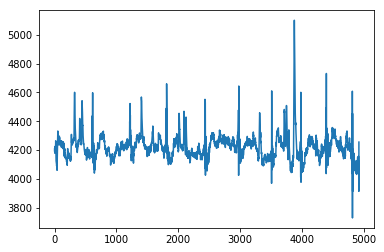

In [413]:
plt.plot(brain_data[-7].T[0])

In [22]:
brain_music_files

['../../data/Music/animals1_30.12.19_19.00.21.bp.csv',
 '../../data/Music/animals_2_radio_edit_30.12.19_19.13.11.bp.csv',
 '../../data/Music/an_30.12.19_13.43.35.bp.csv',
 '../../data/Music/clench8_30.12.19_23.16.20.bp.csv',
 '../../data/Music/clenching_1_30.12.19_19.11.24.bp.csv',
 '../../data/Music/clench_1_off_3sec_30.12.19_23.12.47.bp.csv',
 '../../data/Music/guitar_30.12.19_14.11.03.bp.csv',
 '../../data/Music/l1_27.12.19_07.50.35.bp.csv',
 '../../data/Music/party_30.12.19_13.50.37.bp.csv',
 '../../data/Music/piano_30.12.19_14.03.09.bp.csv',
 '../../data/Music/selena0.csv',
 '../../data/Music/selena1.csv']

(0.0, 20)

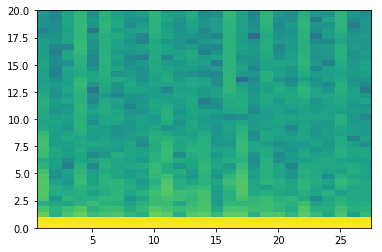

In [23]:
EEG_spectrum, EEG_freq, EEG_time, _ = plt.specgram(brain_data[3].T[0],Fs=128)
plt.ylim(top=20)

In [24]:
brain_music_files

['../../data/Music/animals1_30.12.19_19.00.21.bp.csv',
 '../../data/Music/animals_2_radio_edit_30.12.19_19.13.11.bp.csv',
 '../../data/Music/an_30.12.19_13.43.35.bp.csv',
 '../../data/Music/clench8_30.12.19_23.16.20.bp.csv',
 '../../data/Music/clenching_1_30.12.19_19.11.24.bp.csv',
 '../../data/Music/clench_1_off_3sec_30.12.19_23.12.47.bp.csv',
 '../../data/Music/guitar_30.12.19_14.11.03.bp.csv',
 '../../data/Music/l1_27.12.19_07.50.35.bp.csv',
 '../../data/Music/party_30.12.19_13.50.37.bp.csv',
 '../../data/Music/piano_30.12.19_14.03.09.bp.csv',
 '../../data/Music/selena0.csv',
 '../../data/Music/selena1.csv']

In [25]:
music_files

['../../Music/hypothesis_1/Abhi-Toh-Party-Shuru-Hui-Hai_-FULL-VIDEO-Song-Khoobsurat-Badshah-Aastha.wav',
 '../../Music/hypothesis_1/Animals Live Test.wav',
 '../../Music/hypothesis_1/Animals,  Shazam Project Test.wav',
 '../../Music/hypothesis_1/Becky Hill - Sunrise In The East.wav',
 '../../Music/hypothesis_1/Cashmere-CatQuit-ft.-Ariana-GrandeLyrics-_Official-Audio_.wav',
 '../../Music/hypothesis_1/Daya - Insomnia (Lyrics Lyric Video).wav',
 '../../Music/hypothesis_1/Dynoro & Gigi DAgostino - In My Mind.wav',
 '../../Music/hypothesis_1/Instrumental Music Yiruma - River Flows In You.wav',
 '../../Music/hypothesis_1/Maroon-5-Maps-_Lyric-Video_.wav',
 '../../Music/hypothesis_1/Martin Garrix - Animals.wav',
 '../../Music/hypothesis_1/Nick-Jonas-_-Nicki-Minaj-Bom-Bidi-Bom-_Lyrics_-_Fifty-Shades-Darker_-HD.wav',
 '../../Music/hypothesis_1/Passenger-Let-Her-Go-Fingerstyle-Guitar-Cover-By-James-Bartholomew.wav',
 '../../Music/hypothesis_1/Thinking out Loud.wav']

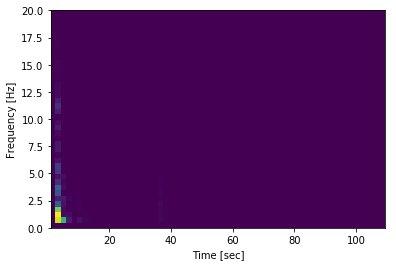

In [26]:
EEGf, EEGt, EEGSxx2 = signal.spectrogram(brain_data[-1].T[3], fs=128) #Spectogram
plt.pcolormesh(EEGt, EEGf, EEGSxx2)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim(top=20)
plt.show()

In [27]:
def find_similarity(a,b):
    """
    Finds the similarity between EEG data file #1 vs. EEG data file #2.
    """
    for i in range(len(a)):
        pass

In [28]:
def percent_calculator(A, B):
    """
    Finds the distribution from SAMPLE based on TEST data.
    Uses jacard similarity.
    """
    intersection = 0
    union = 0
    for a,b in zip(A,B):
        if(bool_similarity_threshold_set(a,b)):
            intersection += 1
    union = abs(len(A) + len(B) - intersection)
    percent = intersection/float(union)
    return percent

In [29]:
a = 100
b = 99
c = (a-b)**2
d = (a*b)/c
d*0.05

495.0

In [30]:
Sxx.mean(), Sxx1.mean()

(974.03754, 3580.1614)

In [31]:
brain_music_files

['../../data/Music/animals1_30.12.19_19.00.21.bp.csv',
 '../../data/Music/animals_2_radio_edit_30.12.19_19.13.11.bp.csv',
 '../../data/Music/an_30.12.19_13.43.35.bp.csv',
 '../../data/Music/clench8_30.12.19_23.16.20.bp.csv',
 '../../data/Music/clenching_1_30.12.19_19.11.24.bp.csv',
 '../../data/Music/clench_1_off_3sec_30.12.19_23.12.47.bp.csv',
 '../../data/Music/guitar_30.12.19_14.11.03.bp.csv',
 '../../data/Music/l1_27.12.19_07.50.35.bp.csv',
 '../../data/Music/party_30.12.19_13.50.37.bp.csv',
 '../../data/Music/piano_30.12.19_14.03.09.bp.csv',
 '../../data/Music/selena0.csv',
 '../../data/Music/selena1.csv']

In [32]:
EEGf, EEGt, EEGSxx1 = signal.spectrogram(brain_data[0].T[0], fs=128) #Spectogram

In [33]:
EEGf, EEGt, EEGSxx2 = signal.spectrogram(brain_data[1].T[0], fs=128) #Spectogram

In [148]:
clench_f, clench_t, clench_Sxx = signal.spectrogram(brain_data[3].T[0], fs=128) #Spectogram

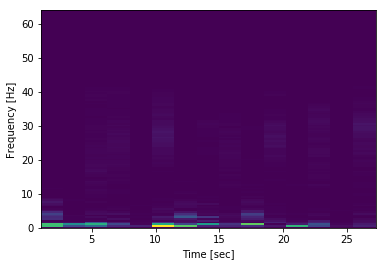

In [150]:
plt.pcolormesh(clench_t, clench_f, clench_Sxx)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

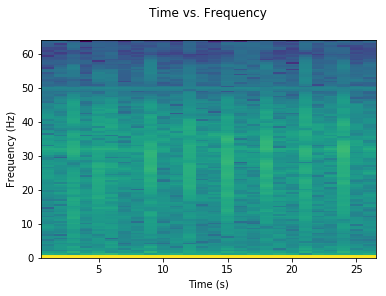

In [129]:
spec, frq, tm, _ = plt.specgram(brain_data[3].T[1][128:], Fs=128)
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.title("Time vs. Frequency", y=1.08)
plt.show()

In [246]:
x = np.array([])
for i in range(32,48):
    x = np.append(x, clench_Sxx[i])

In [247]:
spec.shape

(129, 26)

In [248]:
brain_data[3].shape

(3618, 5)

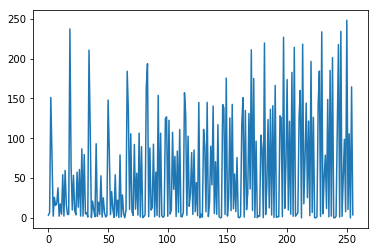

In [249]:
plt.plot(x)

In [250]:
# plot(128, brain_data[3].T[1][128:512], True)

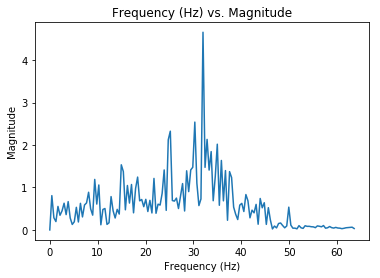

In [338]:
mag, frq = plot(128, brain_data[3].T[1][-300:], True)

In [265]:
frq[mag.argmax()], mag[mag.argmax()]

(32.0, 4.656461371110234)

In [415]:
x = brain_data[3].T[4][128:]
x = abs(x - np.average(x))  # biasing.

In [416]:
peaks, props = signal.find_peaks(x, distance=384)

In [418]:
peaks, peaks.shape[0], x[348]

(array([ 348,  734, 1122, 1512, 1898, 2306, 3040, 3434], dtype=int64),
 8,
 617.2991069077361)

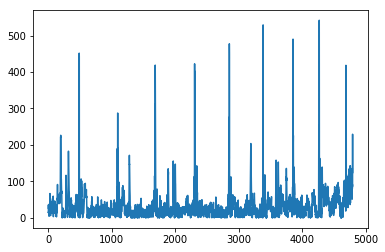

In [403]:
plt.plot(x)

In [254]:
clench_Sxx.shape

(129, 16)

In [36]:
toge = list(clench_Sxx[0])
for x in range(1, clench_Sxx.shape[0]):
    toge.extend(list(clench_Sxx[x]))


In [37]:
len(toge)

2064

In [38]:
brain_music_files[0]

'../../data/Music/animals1_30.12.19_19.00.21.bp.csv'

In [39]:
EEGSxx1.mean(), EEGSxx2.mean()

(24.876469715298764, 25.38273768723753)

In [40]:
RADIUS = 1
def bool_similarity_threshold_set(A, B):
    """
    bool function to detect for any intersection between two areas of two circles with centers @ A, B.
    """
    return bool(abs(A-B) < RADIUS)

In [41]:
pct = 0
for i in range(EEGSxx1.shape[0]):
    pct += percent_calculator(EEGSxx1[i], EEGSxx2[i])
pct /= Sxx.shape[0]
pct

0.36819687608075585

In [42]:
# music_files

In [43]:
EEGf, EEGt, Sxx1 = signal.spectrogram(data[-4][1], fs=data[0][0]) #Spectogram
EEGf, EEGt, Sxx2 = signal.spectrogram(data[-6][1], fs=data[0][0]) #Spectogram

In [44]:
pct = 0
for i in range(Sxx1.shape[0]):
    pct += percent_calculator(Sxx1[i], Sxx2[i])
pct /= Sxx.shape[0]
pct

0.2962396372467088

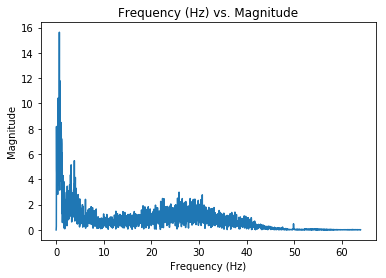

In [45]:
magnitude, frequencies = plot(128, brain_data[3].T[0], True)